In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [37]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [38]:
# Step 1: Load the dataset
data = pd.read_csv("TempNY.csv")
data

,Year,Average,Unnamed: 2
0,1870,53.60,NaN
1,1871,51.13,NaN
2,1872,50.98,NaN
3,1873,50.98,NaN
4,1874,51.34,NaN
...,...,...,...
146,2016,57.18,NaN
147,2017,56.22,NaN
148,2018,55.88,NaN
149,2019,55.62,NaN


In [39]:
data["Year"] = pd.to_datetime(data["Year"], format="%Y")
data.set_index("Year", inplace=True)
data.head()

,Average,Unnamed: 2
Year,,
1870-01-01,53.60,NaN
1871-01-01,51.13,NaN
1872-01-01,50.98,NaN
1873-01-01,50.98,NaN
1874-01-01,51.34,NaN


In [40]:
# Remove the last column
data = data.drop(data.columns[-1], axis=1)
data.head()

,Average
Year,
1870-01-01,53.60
1871-01-01,51.13
1872-01-01,50.98
1873-01-01,50.98
1874-01-01,51.34


In [41]:
data.rename(columns={"Average": "Temperature"}, inplace=True)
data.head()

,Temperature
Year,
1870-01-01,53.60
1871-01-01,51.13
1872-01-01,50.98
1873-01-01,50.98
1874-01-01,51.34


In [42]:
temperature_series = data["Temperature"]
temperature_series.head()

Year
1870-01-01    53.60
1871-01-01    51.13
1872-01-01    50.98
1873-01-01    50.98
1874-01-01    51.34
Name: Temperature, dtype: float64

In [43]:
# Step 2: Dickey-Fuller test to check stationarity
result = adfuller(temperature_series)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -0.7191855951167331
p-value: 0.8417172538965364
Critical Values: {'1%': np.float64(-3.4779446621720114), '5%': np.float64(-2.8824156122448983), '10%': np.float64(-2.577901887755102)}


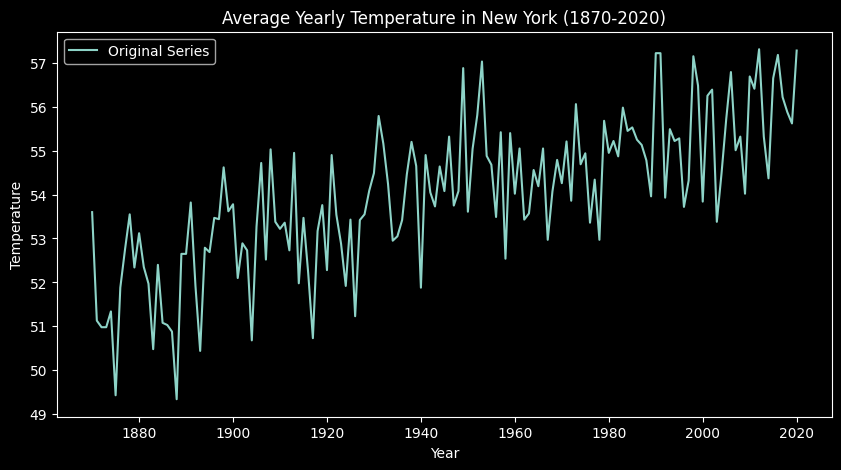

In [44]:
# Plotting the original series
plt.figure(figsize=(10, 5))
plt.plot(temperature_series, label="Original Series")
plt.title("Average Yearly Temperature in New York (1870-2020)")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend()
plt.show()

ADF Statistic after differencing: -8.567649019584678
p-value after differencing: 8.361907414786182e-14


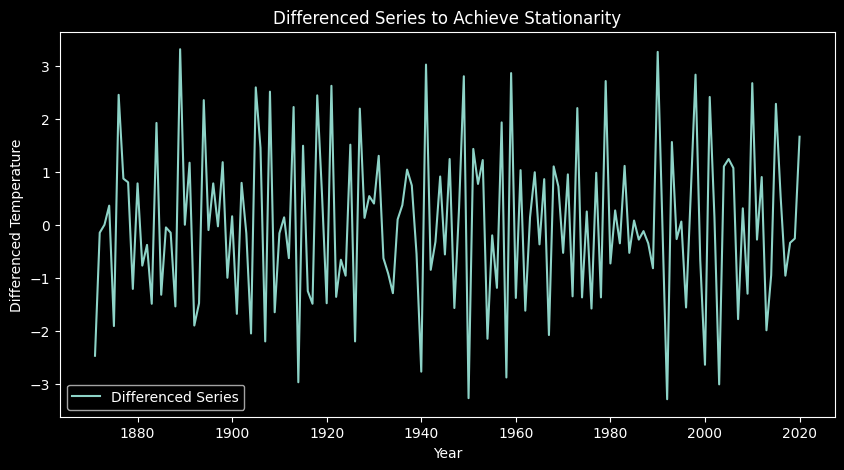

In [45]:
# Step 3: Differencing to achieve stationarity if necessary
if result[1] > 0.05:  # If p-value > 0.05, series is non-stationary
    diff_series = temperature_series.diff().dropna()
    result_diff = adfuller(diff_series)
    print("ADF Statistic after differencing:", result_diff[0])
    print("p-value after differencing:", result_diff[1])

    # Plot the differenced series
    plt.figure(figsize=(10, 5))
    plt.plot(diff_series, label="Differenced Series")
    plt.title("Differenced Series to Achieve Stationarity")
    plt.xlabel("Year")
    plt.ylabel("Differenced Temperature")
    plt.legend()
    plt.show()

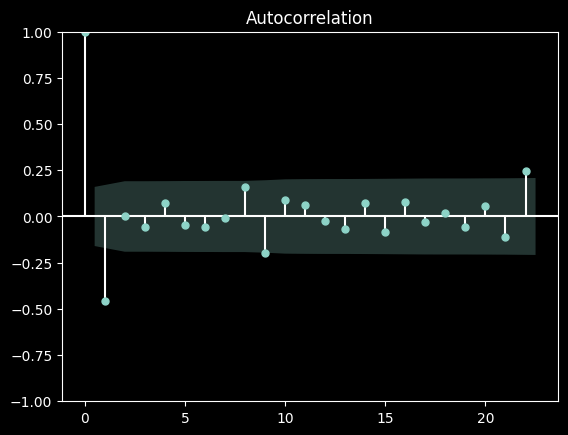

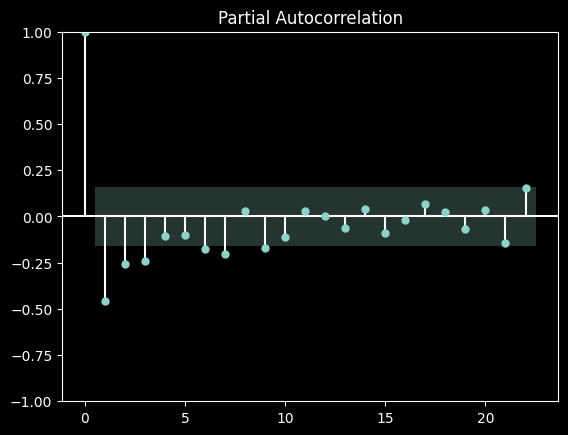

In [46]:
# Step 4: Plot ACF and PACF to identify potential ARIMA parameters
plot_acf(diff_series)
plot_pacf(diff_series)
plt.show()

In [47]:
# Step 5: Train-test split (90% train, 10% test)
train_size = int(len(temperature_series) * 0.9)
train_data, test_data = temperature_series[:train_size], temperature_series[train_size:]

In [48]:
# Step 6: ARIMA model selection based on AIC
# Test six combinations of (p, d, q) with d=1 based on Dickey-Fuller
orders = [(1, 1, 1), (2, 1, 1), (1, 1, 2), (2, 1, 2), (3, 1, 1), (1, 1, 3)]
aic_values = {}

for order in orders:
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    aic_values[order] = model_fit.aic
    print(f"ARIMA{order} - AIC: {model_fit.aic}")

ARIMA(1, 1, 1) - AIC: 435.2301153579871
ARIMA(2, 1, 1) - AIC: 436.82414714507553
ARIMA(1, 1, 2) - AIC: 437.02587579785137
ARIMA(2, 1, 2) - AIC: 436.81338083425214
ARIMA(3, 1, 1) - AIC: 438.81834998387285
ARIMA(1, 1, 3) - AIC: 435.4477077587062


In [49]:
# Choose the order with the lowest AIC
optimal_order = min(aic_values, key=aic_values.get)
print(f"Optimal ARIMA order: {optimal_order}")

Optimal ARIMA order: (1, 1, 1)


In [50]:
# Step 7: Fit the optimal ARIMA model and forecast
model = ARIMA(train_data, order=optimal_order)
model_fit = model.fit()

# Forecast on the test set and get confidence intervals
forecast = model_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int(alpha=0.1)  # 90% confidence interval

In [51]:
# Step 8: Evaluate the model
mse = mean_squared_error(test_data, forecast_mean)
mape = mean_absolute_percentage_error(test_data, forecast_mean)
print(f"Test Set MSE: {mse}")
print(f"Test Set MAPE: {mape}")

Test Set MSE: 1.7322657370442116
Test Set MAPE: 0.019919245925713803


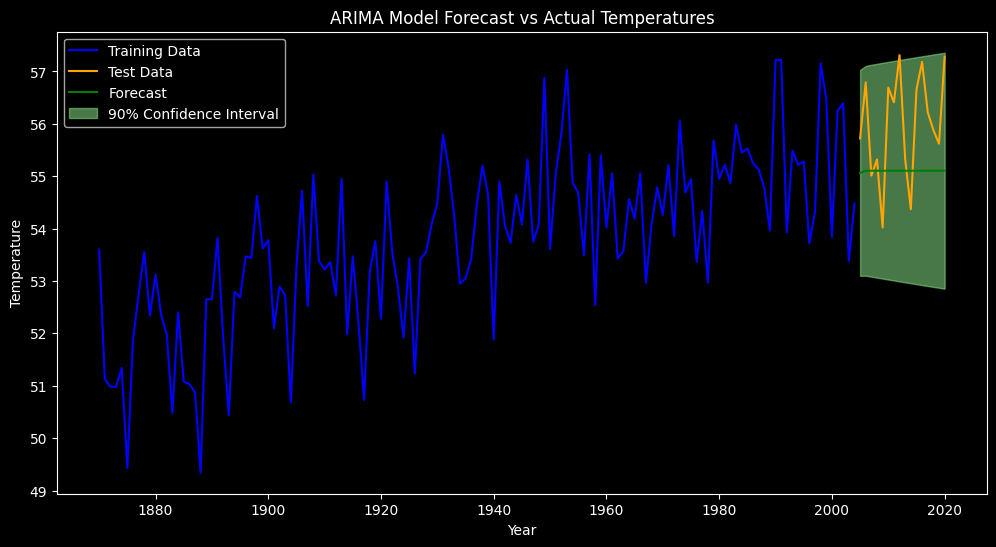

In [52]:
# Step 9: Plotting results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label="Training Data", color="blue")
plt.plot(test_data.index, test_data, label="Test Data", color="orange")
plt.plot(test_data.index, forecast_mean, label="Forecast", color="green")
plt.fill_between(
    test_data.index,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color="lightgreen",
    alpha=0.5,
    label="90% Confidence Interval",
)
plt.title("ARIMA Model Forecast vs Actual Temperatures")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend()
plt.show()

### Forecast reliability:
- The low MAPE value indicates that the model's predictions are relatively accurate, especially if the MAPE is below 10%.
- The MSE provides an idea of the model's average error magnitude.